In [1]:
# Looking at file name and extract information about the Class Label

import pandas as pd
import glob
from collections import Counter

filenames = glob.glob("../input/Audio_*_Actors_01-24/Actor_*/*.wav")

    Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):

    Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440. 
    Song file (Audio_Song_Actors_01-24.zip, 198 MB) contains 1012 files: 44 trials per actor x 23 actors = 1012.
    
    
    Each of the RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

    Filename identifiers 
        Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
        Vocal channel (01 = speech, 02 = song).
        Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
        Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
        Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
        Repetition (01 = 1st repetition, 02 = 2nd repetition).
        Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    Filename example: 02-01-06-01-02-01-12.mp4 
        Video-only (02)
        Speech (01)
        Fearful (06)
        Normal intensity (01)
        Statement "dogs" (02)
        1st Repetition (01)
        12th Actor (12)
        Female, as the actor ID number is even.

In [2]:
emotions_id={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
label_counts = dict(Counter([x.split('/')[-1].split('-')[2] for x in filenames]))
label_counts = {emotions_id[k]:v for k,v in label_counts.items()}
label_counts

{'calm': 1012, 'neutral': 1440}

    Note: If we go about creating a classifier for all the 8 emotions we might have to look out for 
          class imballance for the 3 downsampled class (['neutral', 'disgust', 'surprised'])
          The way to take care of them would be:
          1. Not to look at Accuracy as a metric for validation/train
          2. We can go about Tree based algorithms (eg: XGBoost) where we can specify class weights for prediction neutrality.
          
          
          We can also drop those classes and train a classifier to only detect the balanced classes [happy, sad, fearful, angry, calm]

In [3]:
# Lets visualise how a single sound File looks like and its features
fid = filenames[200]
print(fid)

../input\Audio_Song_Actors_01-24\Actor_05\03-02-04-02-01-01-05.wav


In [4]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np

In [6]:
sf = soundfile.SoundFile(fid)
data = sf.read(dtype="float32")
sample_rate = sf.samplerate

In [7]:
sf

SoundFile('../input\\Audio_Song_Actors_01-24\\Actor_05\\03-02-04-02-01-01-05.wav', mode='r', samplerate=48000, channels=1, format='WAV', subtype='PCM_16', endian='FILE')

In [8]:
data[:10]

array([1.2207031e-04, 9.1552734e-05, 9.1552734e-05, 9.1552734e-05,
       9.1552734e-05, 9.1552734e-05, 9.1552734e-05, 9.1552734e-05,
       1.2207031e-04, 9.1552734e-05], dtype=float32)

In [9]:
duration = data.shape[0]/sample_rate
duration

4.137458333333333

In [10]:
sample_rate

48000

In [11]:
import IPython.display as ipd
ipd.Audio(fid)

### EXPLORATION

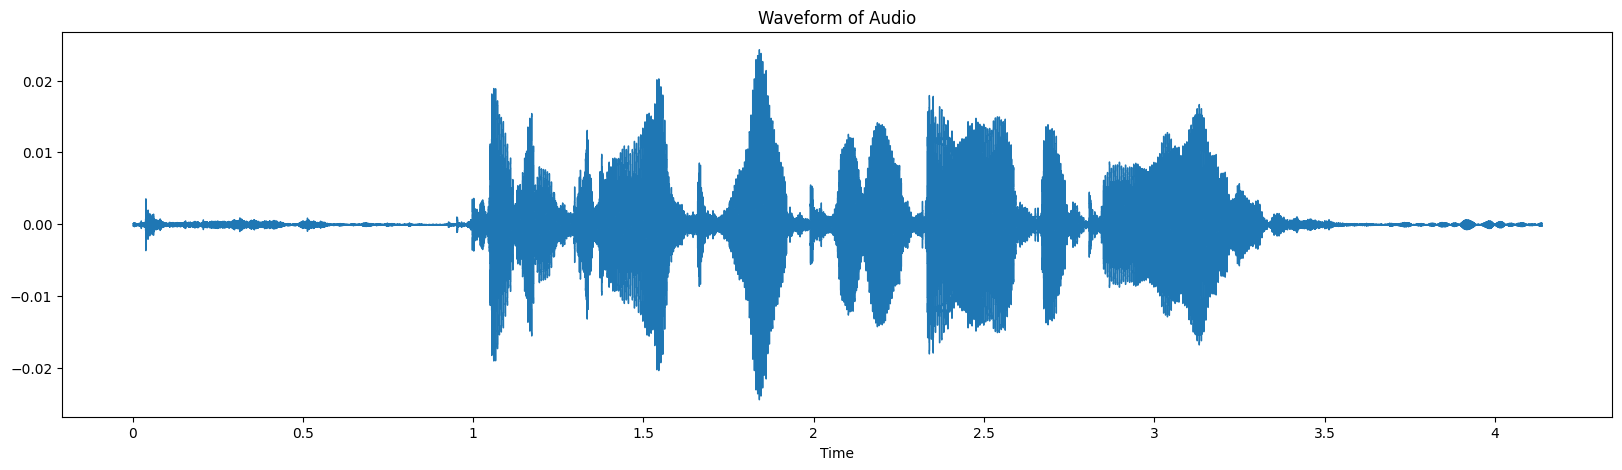

In [12]:
import matplotlib.pyplot as plt

# Plot the waveform using waveshow
plt.figure(figsize=(20, 5))
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Waveform of Audio')
plt.show()

In [13]:
# # Waveplot
# %matplotlib inline
# import matplotlib.pyplot as plt
# import librosa.display
# plt.figure(figsize=(20, 5))
# librosa.display.waveplot(data, sr=sample_rate)

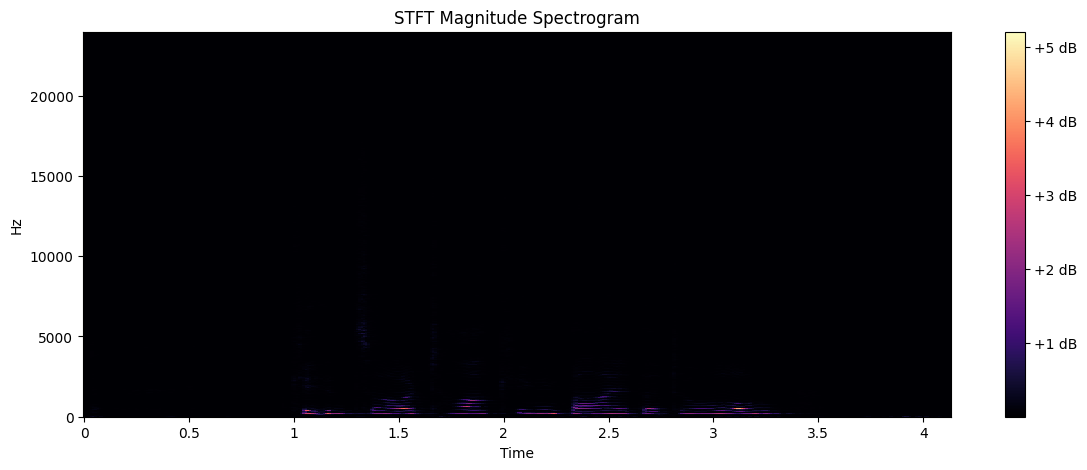

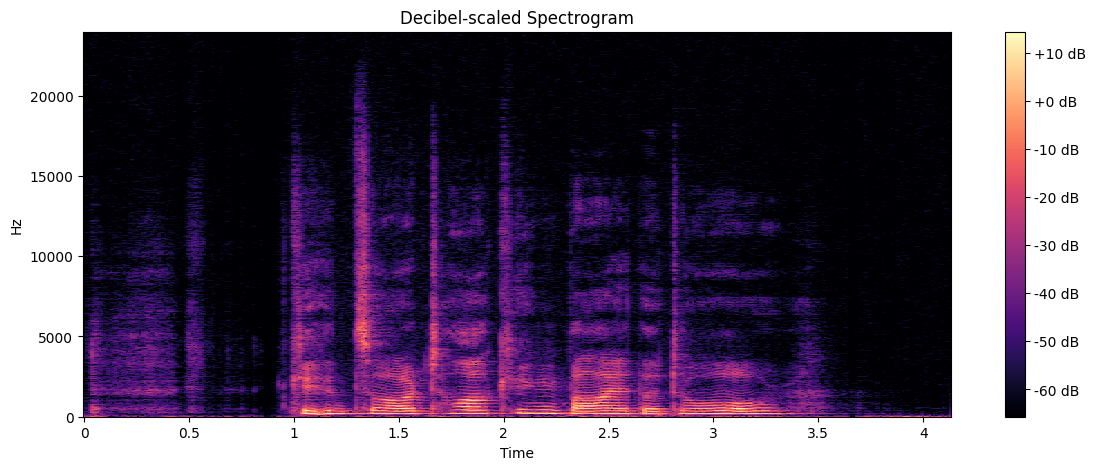

In [14]:
# Computing the Short-Time Fourier Transform (STFT)
x_stft = librosa.stft(data)

# Converting the amplitude to decibels (log scale)
x_db = librosa.amplitude_to_db(abs(x_stft))

# Plotting the raw STFT spectrogram (not usually done this way, for comparison)
plt.figure(figsize=(14, 5))
librosa.display.specshow(abs(x_stft), sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('STFT Magnitude Spectrogram')
plt.colorbar(format="%+2.0f dB")
plt.show()

# Plotting the decibel-scaled spectrogram (this is the more common visualization)
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_db, sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('Decibel-scaled Spectrogram')
plt.colorbar(format="%+2.0f dB")
plt.show()


Shape of Mel Spectrogram: (128, 388)


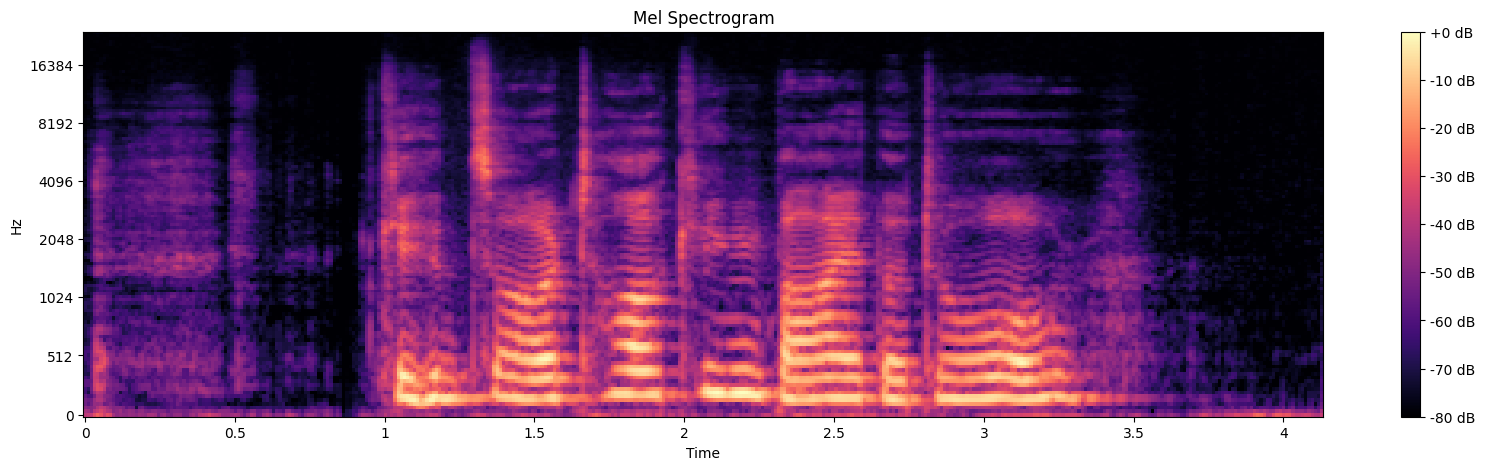

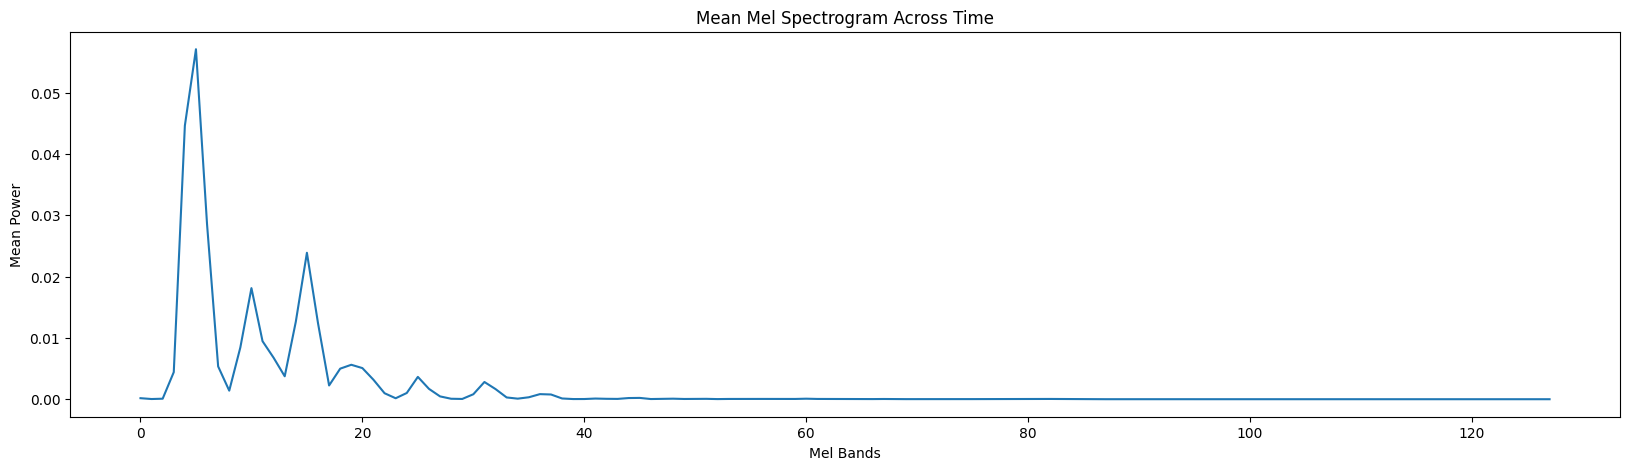

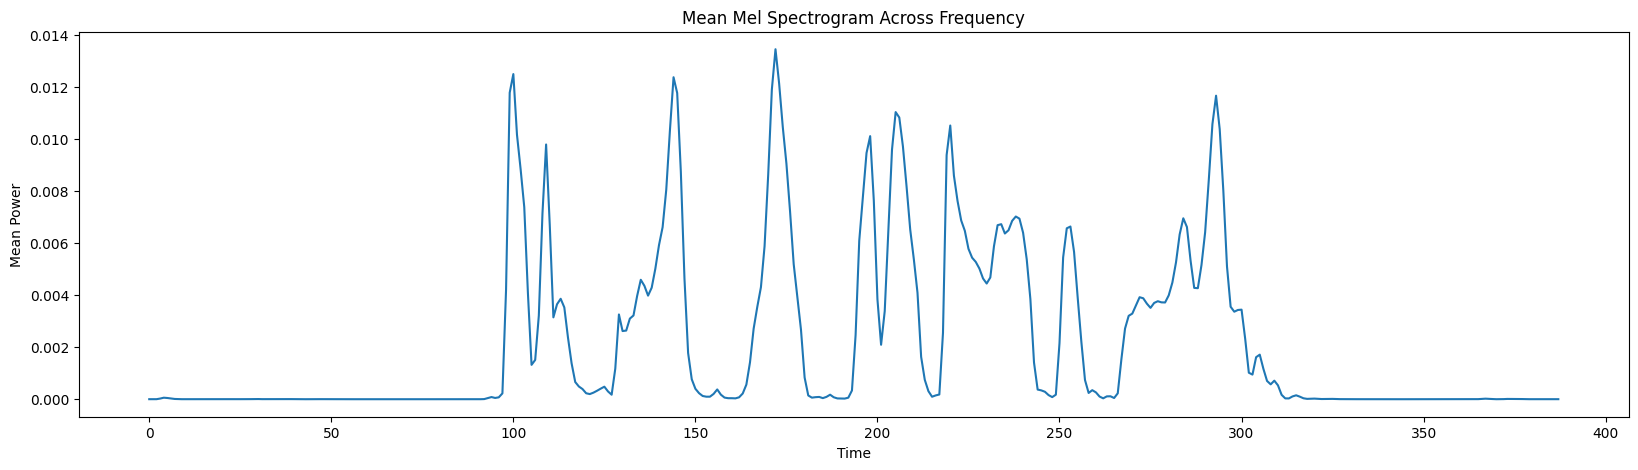

In [15]:
# Computing a Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=data, sr=sample_rate)
print('Shape of Mel Spectrogram:', mel_spec.shape)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                         sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

# Ploting the mean of the Mel spectrogram across time (mean per frequency band)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=1))
plt.title('Mean Mel Spectrogram Across Time')
plt.xlabel('Mel Bands')
plt.ylabel('Mean Power')
plt.show()

# Ploting the mean of the Mel spectrogram across frequency (mean per time frame)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=0))
plt.title('Mean Mel Spectrogram Across Frequency')
plt.xlabel('Time')
plt.ylabel('Mean Power')
plt.show()


In [16]:
# # mel_scpetrogram
# mel_spec = librosa.feature.melspectrogram(data, sr=sample_rate )
# print('shape:', mel_spec.shape)
# plt.figure(figsize=(20, 5))
# librosa.display.specshow(mel_spec, sr=sample_rate, x_axis='time')

# plt.figure(figsize=(20, 5))
# plt.plot(np.mean(mel_spec, axis=0))

# plt.figure(figsize=(20, 5))
# plt.plot(np.mean(mel_spec, axis=1))

Shape of Chroma Spectrogram: (12, 388)


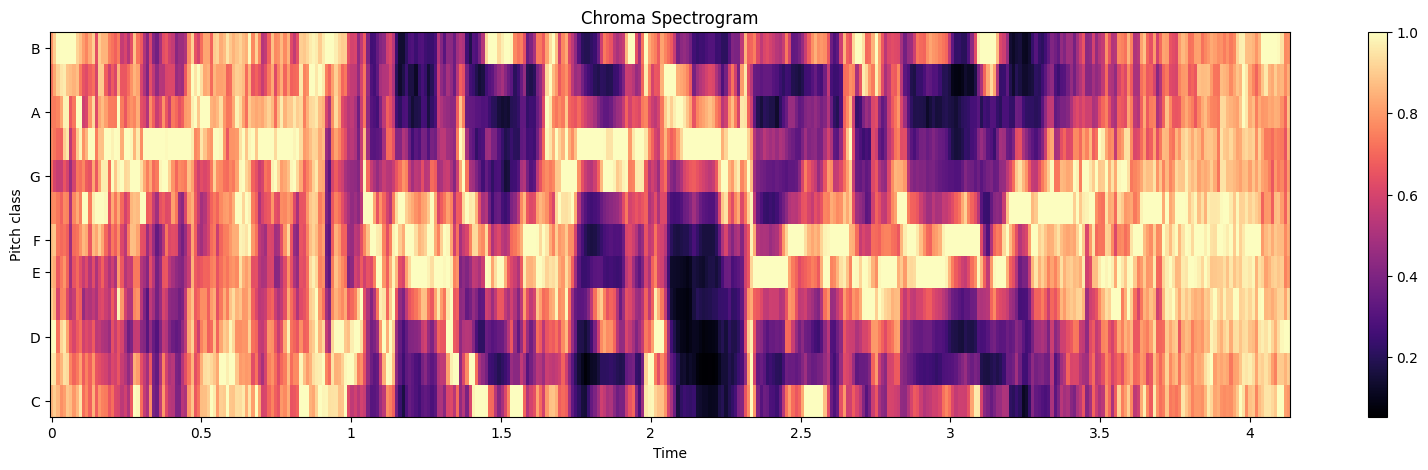

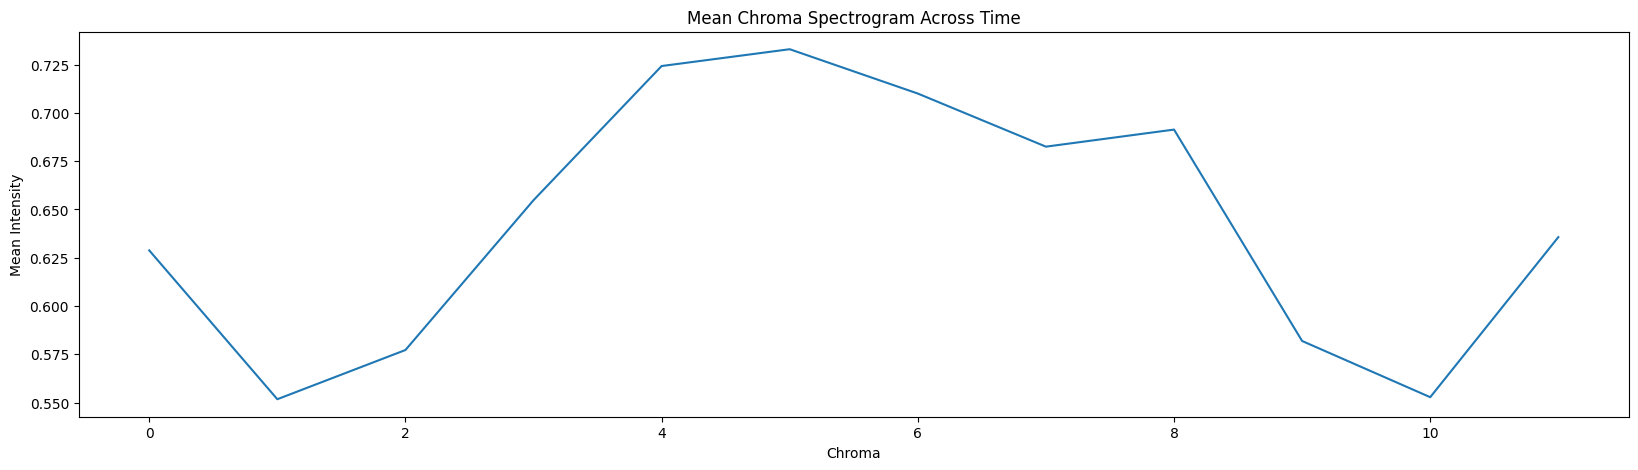

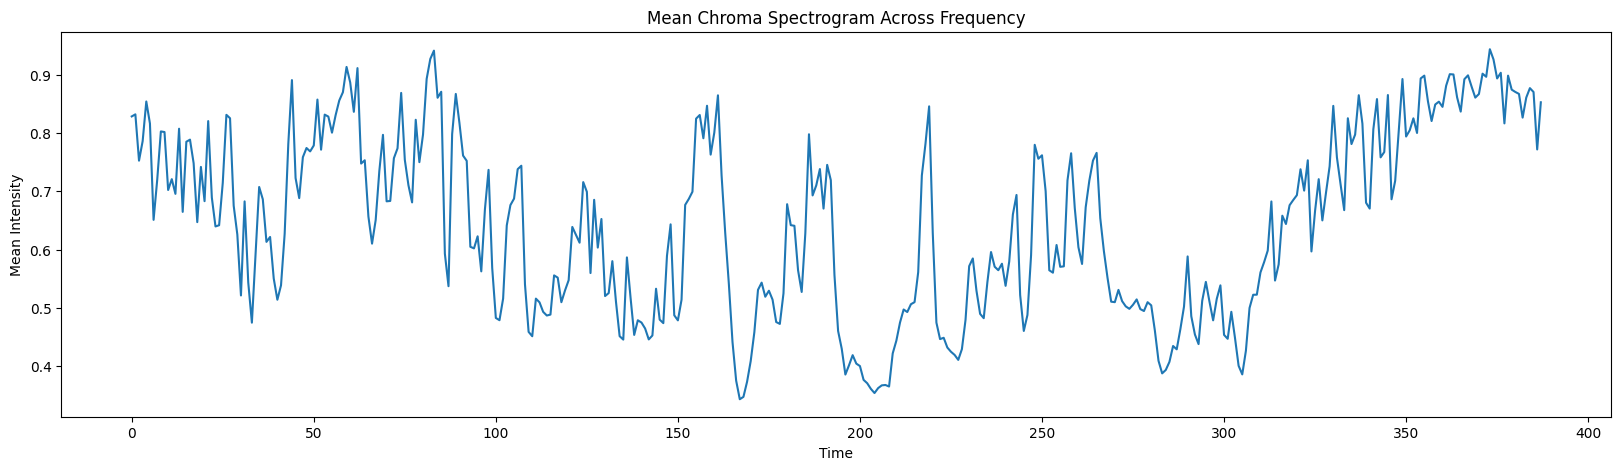

In [17]:
# Computing the Short-Time Fourier Transform (STFT)
x_stft = librosa.stft(data)

# Computing the Chroma STFT (Chroma Spectrogram)
chroma = librosa.feature.chroma_stft(S=np.abs(x_stft), sr=sample_rate, n_chroma=12)
print('Shape of Chroma Spectrogram:', chroma.shape)

# Plot the Chroma Spectrogram
plt.figure(figsize=(20, 5))
librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma Spectrogram')
plt.show()

# Plot the mean of the Chroma Spectrogram across time (mean per chroma band)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(chroma, axis=1))
plt.title('Mean Chroma Spectrogram Across Time')
plt.xlabel('Chroma')
plt.ylabel('Mean Intensity')
plt.show()

# Plot the mean of the Chroma Spectrogram across frequency (mean per time frame)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(chroma, axis=0))
plt.title('Mean Chroma Spectrogram Across Frequency')
plt.xlabel('Time')
plt.ylabel('Mean Intensity')
plt.show()

In [18]:
# #chroma sftt (chroma spectogram)
# x_stft = librosa.stft(data)
# chroma = librosa.feature.chroma_stft(S=x_stft, sr=sample_rate, n_chroma=13)
# print('shape:' ,chroma.shape)
# plt.figure(figsize=(20, 5))
# librosa.display.specshow(chroma, sr=sample_rate, x_axis='time')


# plt.figure(figsize=(20, 5))
# plt.plot(np.mean(np.real(chroma), axis=0))

# plt.figure(figsize=(20, 5))
# plt.plot(np.mean(np.real(chroma), axis=1))

Shape of MFCCs: (13, 388)


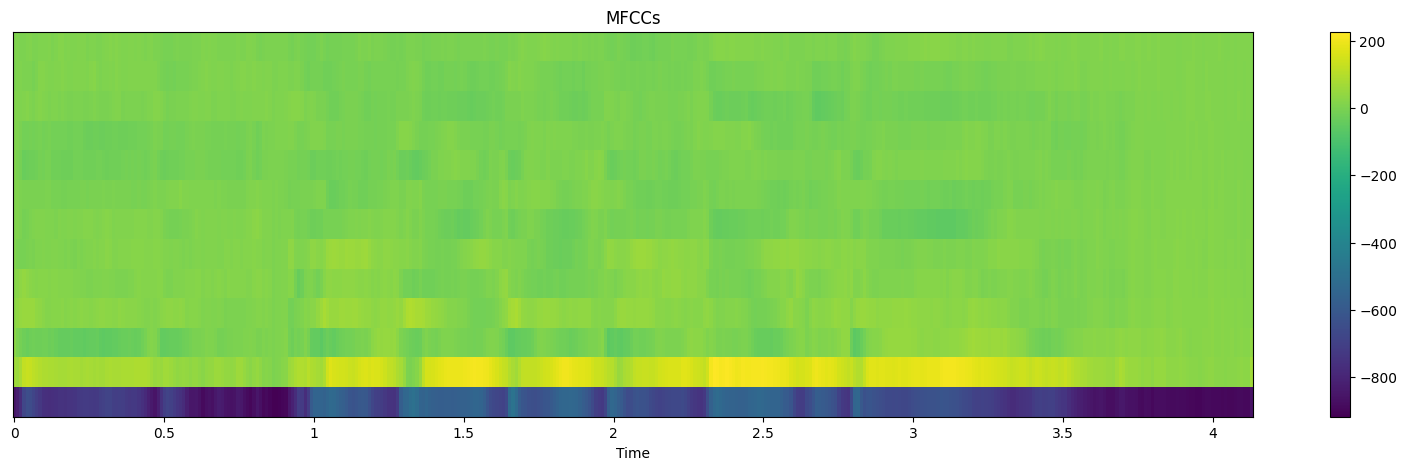

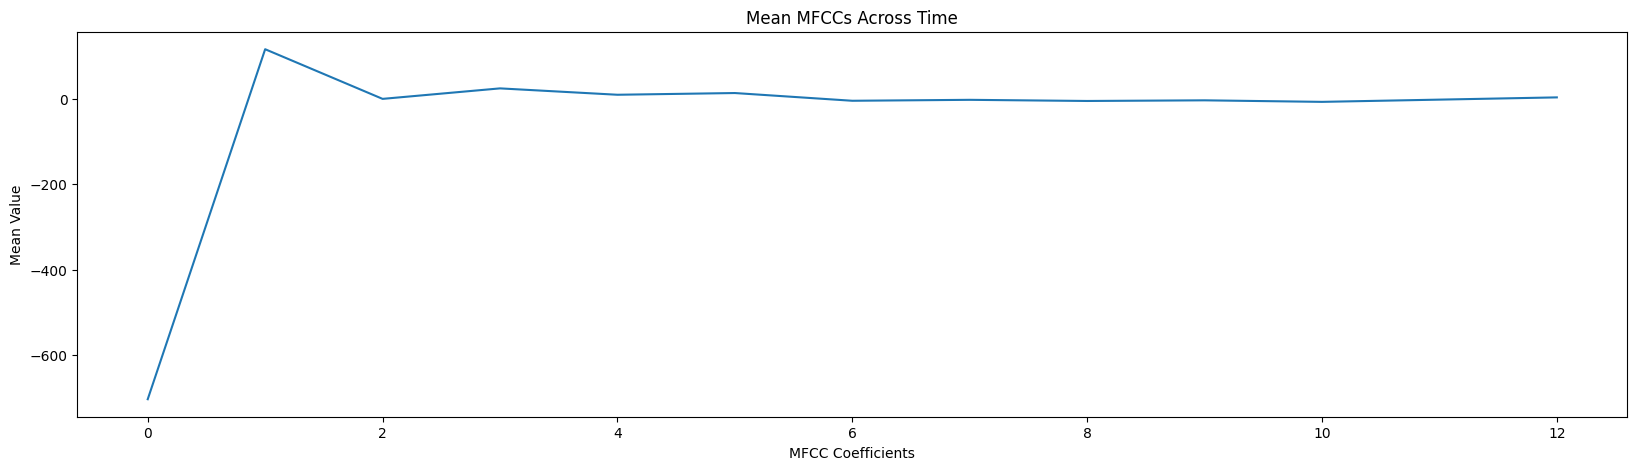

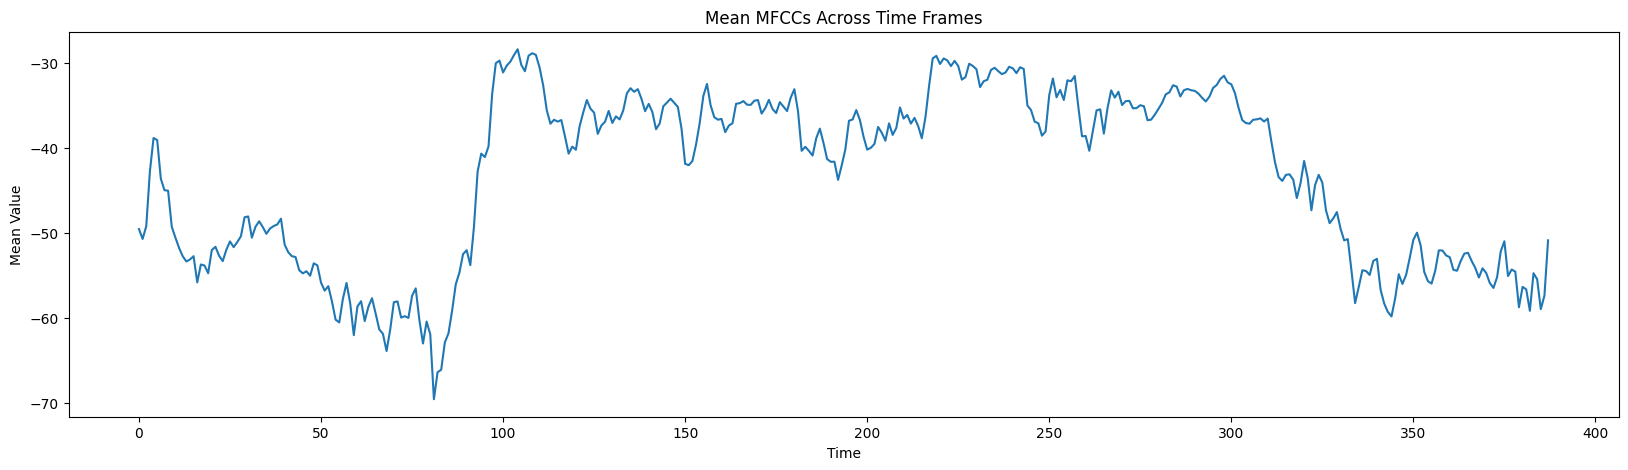

In [19]:
# MFCCs (Mel-Frequency Cepstral Coefficients)
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
print('Shape of MFCCs:', mfccs.shape)

# Plot the MFCCs as a spectrogram
plt.figure(figsize=(20, 5))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('MFCCs')
plt.show()

# Plot the mean of the MFCCs across time (mean per coefficient)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=1))
plt.title('Mean MFCCs Across Time')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Mean Value')
plt.show()

# Plot the mean of the MFCCs across coefficients (mean per time frame)
plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=0))
plt.title('Mean MFCCs Across Time Frames')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.show()

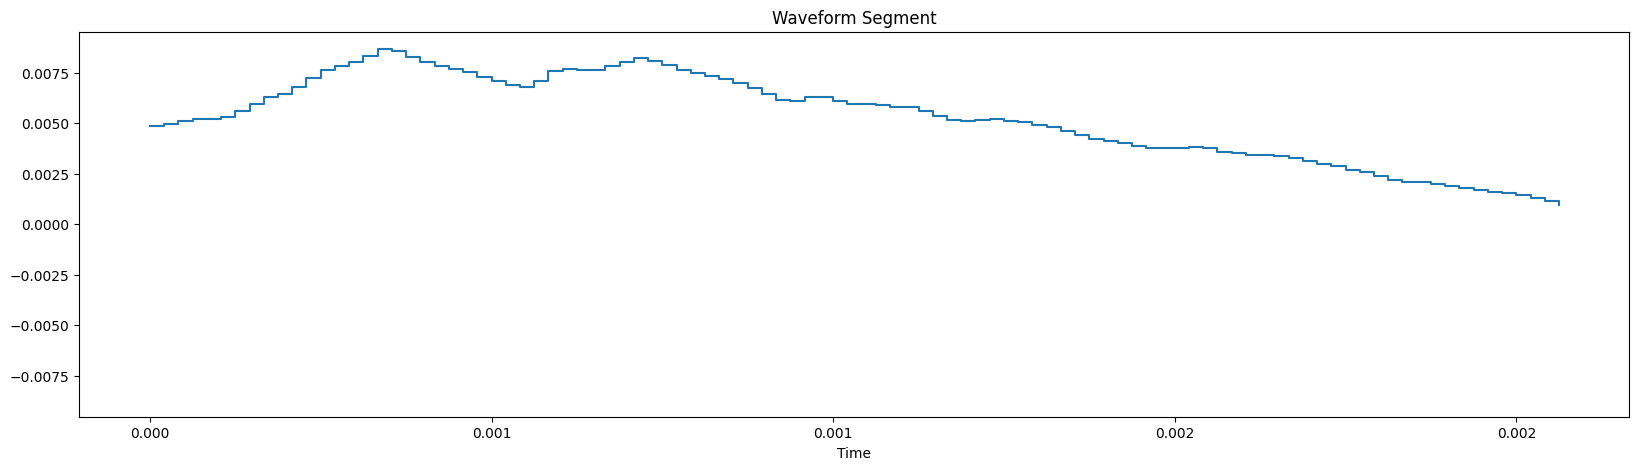

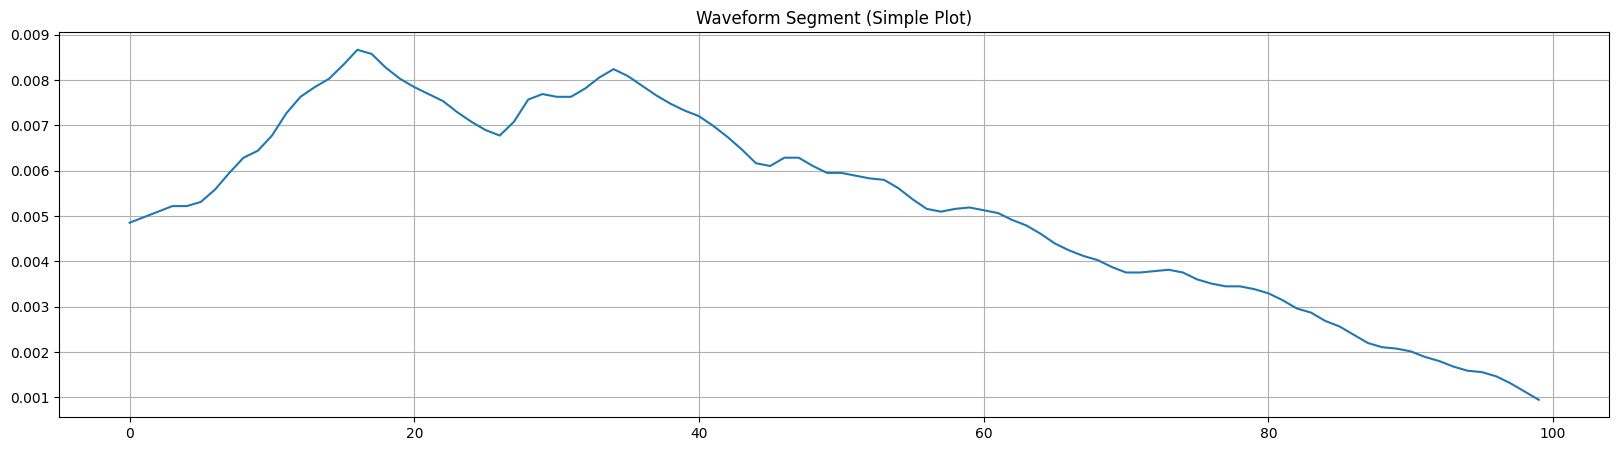

Number of Zero Crossings in the interval: 0


In [20]:
# Zerocrossings
plt.figure(figsize=(20, 5))
librosa.display.waveshow(data[100000:100100], sr=sample_rate)
plt.title('Waveform Segment')
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(data[100000:100100])
plt.title('Waveform Segment (Simple Plot)')
plt.grid(True)
plt.show()

zero_crossings = librosa.zero_crossings(data[100000:100100], pad=False)
print('Number of Zero Crossings in the interval:', sum(zero_crossings))

### FEATURE EXTRACTION

In [21]:
import librosa
import soundfile as sf
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [22]:
# def extract_feature(file_name, mfcc=True, chroma=True, mel=True, zero_crossing=True):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=24).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))
#         if zero_crossing:
#             zc = sum(librosa.zero_crossings(X, pad=False))
#             result=np.hstack((result, zc))
#     return result

In [23]:

def extract_feature(file_name, mfcc=True, chroma=True, mel=True, zero_crossing=True):
    try:
        with sf.SoundFile(file_name) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate
            result = np.array([])

            # Extract MFCCs
            if mfcc:
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                result = np.hstack((result, mfccs))

            # Extract Chroma feature
            if chroma:
                stft = np.abs(librosa.stft(X))
                chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=24).T, axis=0)
                result = np.hstack((result, chroma))

            # Extract Mel Spectrogram feature
            if mel:
                mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
                result = np.hstack((result, mel))

            # Extract Zero Crossing Rate feature
            if zero_crossing:
              zc = sum(librosa.zero_crossings(X, pad=False))
              result=np.hstack((result, zc))
                
            return result

    except Exception as e:
        print(f"Error extracting features from {file_name}: {e}")
        return None


In [24]:
from collections import Counter

In [25]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
reverse_emotions = {v:k for k,v in emotions.items()}

# observed_emotions=['calm', 'happy', 'fearful', 'disgust'] // 82
observed_emotions=list(emotions.values())


filenames = glob.glob("../input/Audio_*_Actors_01-24/Actor_*/*.wav")

id_counts = dict(Counter([x.split('/')[-1].split('-')[2] for x in filenames]))
label_counts = {emotions[k]:v for k,v in id_counts.items()}

In [26]:
def load_data():
    x,y=[],[]
    for file in filenames:
        try:
            file_name=os.path.basename(file)
            emotion=emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                continue
            feature=extract_feature(file)
            x.append(feature)
            y.append(emotion)
        except Exception as e:
            print(e, file)
    return [np.array(x), y]

In [27]:
pip install tensorflow



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import os

In [31]:
def load_data():
    x, y = [], []
    feature_shape = None  # To store the shape of the first feature vector
    
    for file in filenames:
        try:
            file_name = os.path.basename(file)
            emotion = emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                continue
            feature = extract_feature(file)
            if feature is not None:
                if feature_shape is None:
                    feature_shape = feature.shape
                elif feature.shape != feature_shape:
                    # Handle inconsistent shapes: Padding or truncating
                    max_length = max(feature_shape[0], feature.shape[0])
                    feature = np.pad(feature, (0, max(0, max_length - feature.shape[0])), mode='constant')
                    feature = feature[:max_length]
                
                x.append(feature)
                y.append(emotion)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Convert lists to NumPy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


In [32]:
data_x, data_y = load_data()

print("Feature array shape:", data_x.shape)
print("Number of labels:", len(data_y))

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(


Error extracting features from ../input\Audio_Song_Actors_01-24\Actor_24\03-02-01-01-01-01-24.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Error extracting features from ../input\Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-01-02-01.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Error extracting features from ../input\Audio_Speech_Actors_01-24\Actor_01\03-01-08-01-02-02-01.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Error extracting features from ../input\Audio_Speech_Actors_01-24\Actor_05\03-01-02-01-02-02-05.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Error extracti

### KERAS MODEL

In [33]:
#Keras-tf model MLP with Dense

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.001)

In [34]:
reverse_emotions

{'neutral': '01',
 'calm': '02',
 'happy': '03',
 'sad': '04',
 'angry': '05',
 'fearful': '06',
 'disgust': '07',
 'surprised': '08'}

In [35]:
# Data
x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

y_train = to_categorical([int(reverse_emotions[x])-1 for x in y_train])
y_test = to_categorical([int(reverse_emotions[x])-1 for x in y_test])

# Configuration options
feature_vector_length = x_train.shape[1]
num_classes = len(observed_emotions)

input_shape = (feature_vector_length,)

In [36]:
input_shape

(193,)

In [37]:
# INPUT_VECTOR(193) : IN(120) : H(80: 50: 30: 20): OP(8)

In [38]:
# Create the model
np.random.seed(1) # repr


model = Sequential()
model.add(Dense(120, input_shape=input_shape, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

In [39]:
# Configure the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,
                    epochs=1500,
                    batch_size=64,  # Set to a standard batch size
                    verbose=1,
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[early_stop_cb])


Epoch 1/1500


22/22 [==============================] - 11s 89ms/step - loss: 50.9563 - accuracy: 0.1527 - val_loss: 12.1588 - val_accuracy: 0.1195
Epoch 2/1500
22/22 [==============================] - 0s 18ms/step - loss: 11.3391 - accuracy: 0.1373 - val_loss: 11.0470 - val_accuracy: 0.1603
Epoch 3/1500
22/22 [==============================] - 0s 18ms/step - loss: 7.9033 - accuracy: 0.1607 - val_loss: 8.7167 - val_accuracy: 0.0729
Epoch 4/1500
22/22 [==============================] - 0s 17ms/step - loss: 7.2203 - accuracy: 0.1512 - val_loss: 6.8773 - val_accuracy: 0.1312
Epoch 5/1500
22/22 [==============================] - 0s 20ms/step - loss: 9.4010 - accuracy: 0.1614 - val_loss: 8.3140 - val_accuracy: 0.2216
Epoch 6/1500
22/22 [==============================] - 0s 16ms/step - loss: 6.0308 - accuracy: 0.1512 - val_loss: 6.0043 - val_accuracy: 0.1895
Epoch 7/1500
22/22 [==============================] - 0s 17ms/step - loss: 5.8665 - accuracy: 0.1585 - val_loss: 7.3377 - val_accuracy

In [40]:
# Test the model after training
test_results = model.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - accuracy: {test_results[1]}%')

y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

23/23 [==============================] - 0s 2ms/step - loss: 1.8122 - accuracy: 0.2943
Test results - Loss: 1.812198519706726 - accuracy: 0.29427793622016907%
23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.25      0.02      0.03        56
           1       0.41      0.45      0.43       118
           2       1.00      0.01      0.02       110
           3       0.30      0.52      0.38       104
           4       0.69      0.32      0.44       119
           5       0.19      0.63      0.29       101
           6       0.00      0.00      0.00        71
           7       0.17      0.09      0.12        55

    accuracy                           0.29       734
   macro avg       0.38      0.25      0.21       734
weighted avg       0.43      0.29      0.25       734

[[ 1 11  0 38  0  6  0  0]
 [ 2 53  0 34  0 26  0  3]
 [ 0 14  1 14  8 67  0  6]
 [ 0 13  0 54  0 34  0  3]
 [ 0  7  0  5 38 64  0  5]
 [

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [41]:
model.save("../output/keras/keras_model.h5")

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


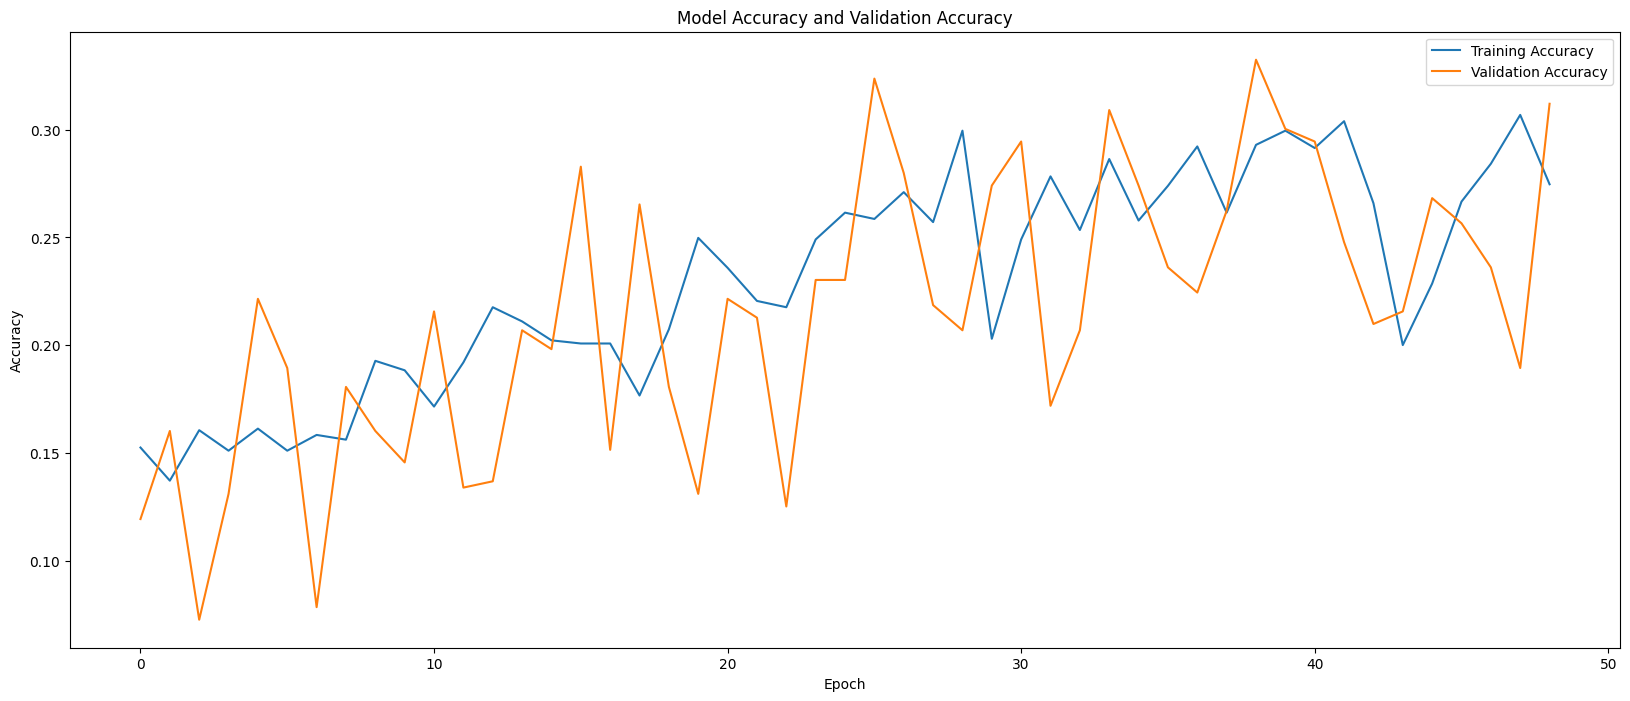

In [42]:

# Ploting accuracy and validation accuracy
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### SKLEARN MODEL

In [43]:
# Train SKlean Model

x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

# Scikit learn model MLP
model=MLPClassifier(
    alpha=0.01, batch_size=8, epsilon=1e-08,random_state=1,
    hidden_layer_sizes=(120,100,80,50,30,20,), learning_rate='adaptive',
    max_iter=1500, verbose=0, n_iter_no_change=150
)

model.fit(x_train,y_train)

y_pred=model.predict(x_test)

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 13.76%


In [44]:
# Tuning Hyperparametrs

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model=MLPClassifier(
    batch_size='auto', epsilon=1e-08,random_state=1,learning_rate='adaptive',
    max_iter=100, verbose=0, n_iter_no_change=10
)
parameters = dict(
    alpha=[0.01, 0.001], hidden_layer_sizes=[(120,50,30,), (120,100,)]
)
clf = GridSearchCV(model, parameters)
clf.fit(x_train,y_train)


sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'param_hidden_layer_sizes',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [45]:
clf.cv_results_

{'mean_fit_time': array([0.99788661, 0.70734992, 0.98160896, 1.03382716]),
 'std_fit_time': array([0.1526978 , 0.17360247, 0.29918045, 0.45066446]),
 'mean_score_time': array([0.00245614, 0.00194263, 0.00223746, 0.00217943]),
 'std_score_time': array([0.00051559, 0.00062656, 0.00039339, 0.00069493]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.001, 0.001],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(120, 50, 30), (120, 100), (120, 50, 30), (120, 100)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01, 'hidden_layer_sizes': (120, 50, 30)},
  {'alpha': 0.01, 'hidden_layer_sizes': (120, 100)},
  {'alpha': 0.001, 'hidden_layer_sizes': (120, 50, 30)},
  {'alpha': 0.001, 'hidden_layer_sizes': (120, 100)}],
 'split0_test_score': array([0.16909621, 0.2244898 , 0.19241983, 0.26239067]),
 'split1_test_score':

In [46]:
clf.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (120, 100)}

In [47]:
clf.best_score_

0.2155456668883092

In [48]:
clf.best_estimator_

MLPClassifier(alpha=0.01, hidden_layer_sizes=(120, 100),
              learning_rate='adaptive', max_iter=100, random_state=1,
              verbose=0)

### Running Inference in Notebook
 

In [65]:
from tensorflow.keras.models import load_model

# Defining paths for the inference file and model
infer_file_path='../input/Audio_Song_Actors_01-24/Actor_19/03-02-01-01-01-02-19.wav'
infer_model_path = '../output'
framework = 'keras'  # Can change to 'sklearn' if using sklearn
mode = 'infer'  


def load_infer_data(filepath):
    ''' 
    Function to load the infernece data from filepath and extract the features the same way we did for training.
    '''
    file_name=os.path.basename(filepath)
    feature=np.array(extract_feature(filepath))
    print(feature.shape)
    
    # Printing the feature shape and reshaping it to a single row vector.
    return feature.reshape(1,-1)

In [67]:
if framework == 'keras':
    model = load_model(infer_model_path + '/keras/keras_model.h5')
else:
    with open(infer_model_path + '/sklearn_model.pkl', 'rb') as f:
        model = pickle.load(f)

In [68]:
model

In [69]:
data_x = load_infer_data(infer_file_path)

(193,)


In [70]:
predicted_emotion = model.predict(data_x)

1/1 [==============================] - 1s 560ms/step


In [71]:
predicted_emotion

array([[0.26594982, 0.1543466 , 0.05445653, 0.32361802, 0.01664518,
        0.12367746, 0.01914439, 0.04216205]], dtype=float32)

In [72]:
predicted_emotion_index = np.argmax(predicted_emotion)+1

In [73]:
# Checking the predicted emotion
predicted_emotion_index 

4

In [74]:
# Printing the predicted emotion
print("Predicted Emotion: ", emotions_id['0'+str(predicted_emotion_index)])

Predicted Emotion:  sad


In [75]:
emotions_id

{'01': 'neutral',
 '02': 'calm',
 '03': 'happy',
 '04': 'sad',
 '05': 'angry',
 '06': 'fearful',
 '07': 'disgust',
 '08': 'surprised'}

In [76]:
import joblib 

# Save the model
joblib.dump(model, 'emotion_classifier.pkl')

['emotion_classifier.pkl']

### Running Inference through CLI

In [ ]:
!python engine.py --infer --infer-model-path ./model --infer-file-path '../input/Audio_Song_Actors_01-24/Actor_19/03-02-01-01-01-02-19.wav'
!python engine.py --train --framework keras